## Weather Image Classification using TensorFlow and Keras

#### Objective
The objective of this project is to build a CNN model using TensorFlow and Keras that can classify images of weather conditions. The model is train and test on a dataset of weather images.

#### Technology Used
This project uses the following technologies:

    - Python 3.x
    - TensorFlow 2.x
    - Keras
    - NumPy
    - Matplotlib
    
The model is built using TensorFlow and Keras. NumPy is used for numerical computation and array manipulation, while Matplotlib is used for data visualization.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers

In [2]:
# Define the image parameters
img_height = 256
img_width = 256
batch_size = 32
num_classes = 11

In [3]:
# load the weather dataset uisng timage_dataset_from_directory
image_data = tf.keras.utils.image_dataset_from_directory(
    "weather",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False
)

Found 6862 files belonging to 11 classes.


In [5]:
class_names = image_data.class_names
class_names

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

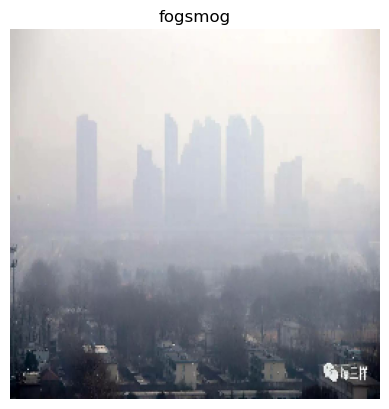

In [6]:
# print the first image 
for image_batch, label_batch in image_data.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off") 
    # while running this plot you have the different result because the shuffle is true

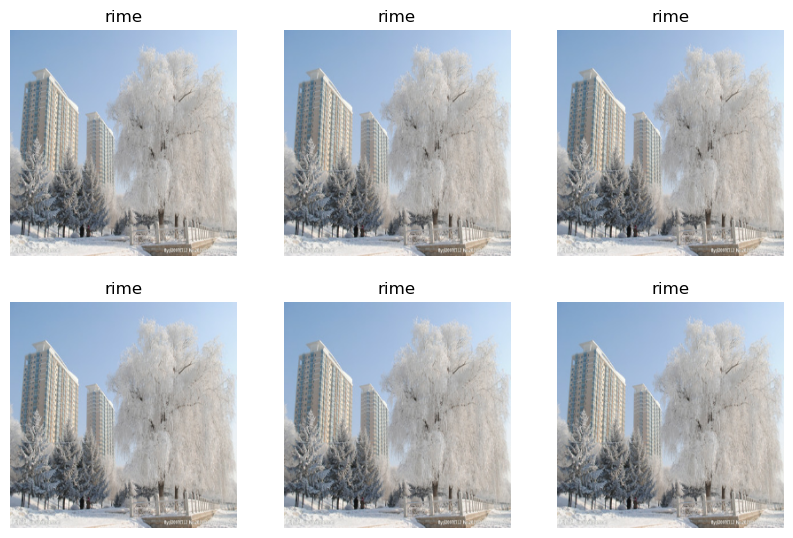

In [11]:
# Display couple of pictures 
plt.figure(figsize =(10,10))

for image_batch, label_batch in image_data.take(1):
    for i in range(6):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[0]])
        plt.axis("off") 

## split dataset

In [17]:
# Split data into train, val and test sets

def get_dataset_partirions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, 
                             shuffle = True, shuffle_size = 10000):
    ds_size = len(image_data)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = image_data.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [18]:
get_dataset_partirions_tf(image_data)

(<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [19]:
train_ds, val_ds, test_ds= get_dataset_partirions_tf(image_data)

In [20]:
len(train_ds), len(val_ds), len(test_ds)

(172, 21, 22)

In [21]:
# Shuffle data
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

## Perform data preprocessing and data augmentation

In [22]:
# Scaling and resizing the image 
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256, 256),
    layers.experimental.preprocessing.Rescaling(1./255) 
])

#### Data augmentation

In [23]:
# Data augmentation to make the data robust
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(
    "horizontal_and_vertical", 
    input_shape=(img_height, img_width,3)), 
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

## Build the CNN model

In [46]:
# define the neural network achitectual 
input_shape = (batch_size, img_width, img_height, 3)

model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
    ]
)

model.build(input_shape = input_shape)

In [47]:
# get the weight----trainable parameters
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 256, 3)             0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

In [48]:
# compile the model
model.compile(
    optimizer ="adam",
    #loss='categorical_crossentropy',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy'])

### Train the model

In [49]:
# fit the model 
history = model.fit(
    train_ds,
    epochs = 10,
    batch_size = batch_size,
    verbose = 1,
    validation_data = val_ds)

Epoch 1/10
172/172 [==============================] - 422s 2s/step - loss: 1.6351 - accuracy: 0.4571 - val_loss: 1.2074 - val_accuracy: 0.5714
Epoch 2/10
172/172 [==============================] - 452s 3s/step - loss: 1.2152 - accuracy: 0.5843 - val_loss: 1.1359 - val_accuracy: 0.5848
Epoch 3/10
172/172 [==============================] - 453s 3s/step - loss: 1.1040 - accuracy: 0.6130 - val_loss: 1.1016 - val_accuracy: 0.6429
Epoch 4/10
172/172 [==============================] - 461s 3s/step - loss: 1.0752 - accuracy: 0.6259 - val_loss: 0.9316 - val_accuracy: 0.6860
Epoch 5/10
172/172 [==============================] - 442s 3s/step - loss: 0.9993 - accuracy: 0.6523 - val_loss: 0.8670 - val_accuracy: 0.7247
Epoch 6/10
172/172 [==============================] - 429s 2s/step - loss: 0.9451 - accuracy: 0.6677 - val_loss: 0.8758 - val_accuracy: 0.6935
Epoch 7/10
172/172 [==============================] - 5516s 32s/step - loss: 0.9247 - accuracy: 0.6742 - val_loss: 0.8939 - val_accuracy: 0.71

### Test the model

In [50]:
# test 
scores = model.evaluate(test_ds)

22/22 [==============================] - 10s 459ms/step - loss: 0.9520 - accuracy: 0.6847


In [51]:
scores 

[0.9519529938697815, 0.6846590638160706]

In [52]:
# check the history params
print(history)
print(history.params)

{'verbose': 1, 'epochs': 10, 'steps': 172}


In [53]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [54]:
# plot thr history keys
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

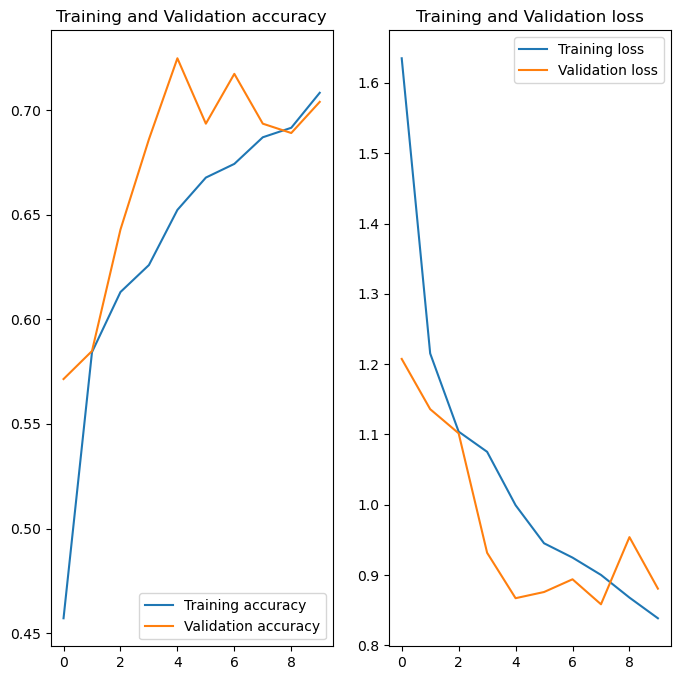

In [55]:
# plot the training and validation accuracy dataset
epochs_range= range(10)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label ="Training accuracy")
plt.plot(epochs_range, val_acc, label ="Validation accuracy")
plt.legend(loc = "lower right")
plt.title('Training and Validation accuracy')

# plot the lost chart
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label ="Training loss")
plt.plot(epochs_range, val_loss, label ="Validation loss")
plt.legend(loc = "upper right")
plt.title('Training and Validation loss')

plt.show()

## Save the model

In [57]:
# Save the model to a file
model.save('weather_cnn_model.h5')